In [1]:
import cv2 as cv
import keras
import keras.applications as apps
import numpy as np
import os
import densenet
import glob
import tqdm
import matplotlib.pyplot as plt
import matplotlib
import random
plt.ion()

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/paperspace/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.callbacks import ModelCheckpoint

In [3]:
TILE_SIZE = 221

In [4]:
net = densenet.DenseNet121(include_top=True,
                      weights=None,
                      input_shape=(221, 221, 2),
                      pooling=None,
                      classes=1)

/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/applications/imagenet_utils.py:258: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


In [5]:
net.load_weights('weights/noise_weights_rand1.hdf5')

In [6]:
def tile_image(HH, HV, conc, tile_size=221):
    # This function assumes all images are the same shape
    tile_center = tile_size//2
    amount_x = (HH.shape[0]//tile_size) -1
    amount_y = (HH.shape[1]//tile_size) -1
    sar_tiles = []
    conc_tiles = []
    for i in range(amount_x):
        for j in range(amount_y):
            x_bounds = [tile_size*i, tile_size*(i+1)]
            y_bounds = [tile_size*j, tile_size*(j+1)]
            conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
            if np.max(conc_tile) != 255:
                HH_tile = HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                HV_tile = HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                tile = np.stack([HH_tile, HV_tile],axis=-1)
                sar_tiles.append(tile)
                conc_tiles.append([conc_tile[tile_center, tile_center]])
    sar_tiles = np.asarray(sar_tiles).astype(np.float32)/255
    conc_tiles = np.asarray(conc_tiles).astype(np.float32)/100
    
    return sar_tiles, conc_tiles
            
            

In [7]:
def predict_image_fine(HH, HV, conc, model, tile_size=221):

    amount_x = ((HH.shape[0])//tile_size) -2
    amount_y = (HH.shape[1]//tile_size) -2
    scan_size = 2
    conc_image = np.zeros((amount_x*(scan_size+1), amount_y*(scan_size+1)))
    for i in tqdm.tqdm(range(amount_x)):
        for j in range(amount_y):
            for s in range(scan_size+1):
                for x in range(scan_size+1):
                    
                    x_bounds = [int(tile_size*(i+ s/scan_size)), int(tile_size*(i+1 + s/scan_size))]
                    y_bounds = [int(tile_size*(j + x/scan_size)), int(tile_size*(j+1 + x/scan_size))]
                    conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
                    if np.max(conc_tile) < 150:
                        HH_tile = HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                        HV_tile = HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                        tile = np.expand_dims(np.stack([HH_tile, HV_tile],axis=-1), axis=0)
                        tile = tile.astype(np.float32)/255
        #                 sar_tiles.append(tile)/
                        pred = model.predict(tile)
                        pval = pred.flatten()[0]
                        if pval > 1.5:
                            pval = np.nan
        #                 print('VAL:', pred)
#                         conc_image[i,j] = pval
                        conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = pval
                    else:
                        conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = np.nan
    return conc_image

In [8]:
def predict_image(HH, HV, conc, model, tile_size=221):
    amount_x = (HH.shape[0]//tile_size) -1
    amount_y = (HH.shape[1]//tile_size) -1
    conc_image = np.zeros((amount_x,amount_y))
    sar_tiles = []
    conc_tiles = []
    for i in range(amount_x):
        for j in range(amount_y):
            x_bounds = [tile_size*i, tile_size*(i+1)]
            y_bounds = [tile_size*j, tile_size*(j+1)]
            conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
            if np.max(conc_tile) < 150:
                HH_tile = HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                HV_tile = HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                tile = np.expand_dims(np.stack([HH_tile, HV_tile],axis=-1), axis=0)
                tile = tile.astype(np.float32)/255
#                 sar_tiles.append(tile)/
                pred = model.predict(tile)
                pval = pred.flatten()[0]
                if pval > 1.5:
                    pval = np.nan
#                 print('VAL:', pred)
                conc_image[i,j] = pval
                
            else:
                conc_image[i,j] = np.nan
    return conc_image

In [9]:
def is_data_valid(folder_path):
    valid = os.path.exists(os.path.join(folder_path, 'imagery_HH.tif'))
    valid = valid and os.path.exists(os.path.join(folder_path, 'imagery_HV.tif')) 
    valid = valid and os.path.exists(os.path.join(folder_path, 'conc.tiff'))
    return valid
    

In [10]:
def read_data(folder):
    hh_image = cv.imread(os.path.join(folder, 'imagery_HH.tif'), cv.IMREAD_GRAYSCALE)
    hv_image = cv.imread(os.path.join(folder, 'imagery_HV.tif'), cv.IMREAD_GRAYSCALE)
    conc_image = cv.imread(os.path.join(folder, 'conc.tiff'), cv.IMREAD_GRAYSCALE)
    return hh_image, hv_image, conc_image

In [11]:
folders = [f for f in glob.glob(os.path.join('training_data/20*')) if is_data_valid(f)]

In [12]:
random.seed(1)

In [13]:
rand_folders = sorted(folders, key=lambda f: random.random())

In [14]:
train_amount = len(rand_folders)//6

In [15]:
training_folders = rand_folders[:-train_amount]
testing_folders = rand_folders[-train_amount:]

In [16]:
def gen_tile_data(folder_name, images, labels, pos, dry_run=False, multiplier=1):
    amount = 0
    try:
        SHIFT = TILE_SIZE//multiplier
        hh_image, hv_image, conc_image = read_data(folder_name)
        conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
        for _ in range(multiplier):
            hh_image = hh_image[SHIFT:, SHIFT:]
            hv_image = hv_image[SHIFT:, SHIFT:]
            conc_image_big = conc_image_big[SHIFT:, SHIFT:]
            im_tiles, c_tiles = tile_image(hh_image, hv_image, conc_image_big)
            if not dry_run:
                images[pos+amount:pos + amount+ len(im_tiles)] = im_tiles
                labels[pos+amount:pos + amount + len(c_tiles)] = c_tiles
            amount = amount + len(im_tiles)
    except:
        print(folder_name)
    if dry_run:
        return amount
    return images, labels, pos + amount

In [17]:
train_length = 0
for k, folder in enumerate(tqdm.tqdm(training_folders)):
    train_length += gen_tile_data(folder, None, None, pos=0, dry_run=True)

 13%|█▎        | 3/23 [00:04<00:32,  1.65s/it]

training_data/20110717B


 74%|███████▍  | 17/23 [00:31<00:11,  1.84s/it]

training_data/20110214


100%|██████████| 23/23 [00:44<00:00,  1.93s/it]


In [18]:
test_length = 0
for k, folder in enumerate(tqdm.tqdm(testing_folders)):
    test_length += gen_tile_data(folder, None, None, pos=0, dry_run=True)

100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


In [19]:
training_images = np.zeros((train_length, TILE_SIZE, TILE_SIZE, 2), dtype=np.float32)
training_labels = np.zeros((train_length, 1), dtype=np.float32)

testing_images = np.zeros((test_length, TILE_SIZE, TILE_SIZE, 2), dtype=np.float32)
testing_labels = np.zeros((test_length, 1), dtype=np.float32)

In [20]:
pos = 0
for k, folder in enumerate(tqdm.tqdm(training_folders)):
    training_images, training_labels, pos = gen_tile_data(folder, training_images, training_labels, pos)

pos = 0
for k, folder in enumerate(tqdm.tqdm(testing_folders)):
    testing_images, testing_labels, pos = gen_tile_data(folder, testing_images, testing_labels, pos)

 13%|█▎        | 3/23 [00:03<00:21,  1.07s/it]

training_data/20110717B


 74%|███████▍  | 17/23 [00:22<00:07,  1.33s/it]

training_data/20110214


100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


In [50]:
# TODO: tune hyper params
optimizer = keras.optimizers.RMSprop(lr=0.00001)
# metrics = ['accuracy']
loss = 'mean_absolute_error'
net.compile(optimizer, loss=loss)

In [52]:
checkpointer = ModelCheckpoint(filepath='weights/noise_weights_abs22.hdf5', verbose=1, save_best_only=True)

In [23]:
hist_loss_noise = []
val_loss_noise = []

In [66]:
net.save_weights('weights/noise_weights_abs222244.hdf5')

In [74]:
hist = net.fit(x=training_images, y=training_labels, epochs=1, validation_data=(testing_images, testing_labels), callbacks=[checkpointer])
hist_loss_noise += hist.history['loss']
val_loss_noise += hist.history['val_loss']

Train on 19183 samples, validate on 4881 samples
Epoch 1/1
19183/19183 [==============================] - 276s 14ms/step - loss: 0.1391 - val_loss: 0.1379

Epoch 00001: val_loss did not improve


In [25]:
import keras.backend as K

In [71]:
 K.get_value(net.optimizer.lr)

0.005

In [73]:
K.set_value(net.optimizer.lr, K.get_value(net.optimizer.lr)/5)

In [ ]:
net_noise.load_weights('check.h5')

In [ ]:
print('h')

In [ ]:
val_loss += hist.history['val_loss']

In [ ]:
hist_loss

In [ ]:
hist = net.fit(x=training_images, y=training_labels, epochs=1, batch_size=32, validation_data=(testing_images, testing_labels))
hist_loss += hist.history['loss']

In [ ]:
for i in range(3):
    hist = net.fit(x=training_images, y=training_labels, epochs=3, validation_data=(testing_images, testing_labels))
    hist_loss += hist.history['loss']

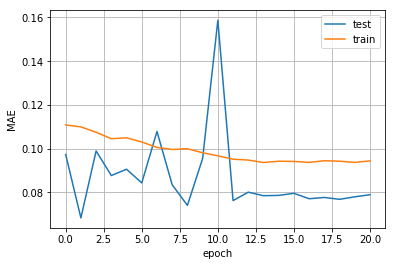

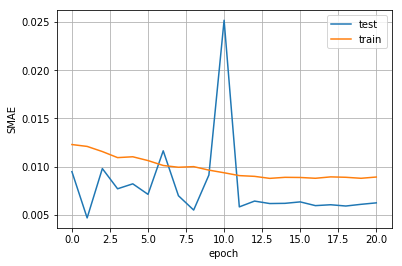

In [61]:
fig = plt.figure()
plt.plot(val_loss_noise, label='test')
plt.plot(hist_loss_noise, label='train')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend()
# fig.get_axes()[0].set_ylim(0, 0.1)
plt.grid()

fig = plt.figure()
plt.plot(np.power(val_loss_noise,2), label='test')
plt.plot(np.power(hist_loss_noise,2), label='train')
plt.ylabel('SMAE')
plt.xlabel('epoch')
plt.legend()
# fig.get_axes()[0].set_ylim(0, 0.1)
plt.grid()

In [ ]:
plt.plot(training_labels.flatten())

In [ ]:
hh_image, hv_image, conc_image = read_data(testing_folders[2])
conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])


In [ ]:
del hh_image
del hv_image
del conc_image

In [ ]:
del training_images

In [ ]:
for test_folder in testing_folders:
    hh_image, hv_image, conc_image = read_data(test_folder)
    conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
    conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)
    image_name = os.path.basename(test_folder) + ".tiff"
    cv.imwrite(image_name, conc)
    print(image_name)

In [ ]:
conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)

In [ ]:
n = matplotlib.colors.Normalize(vmin=0.,vmax=1.)

In [ ]:
# plt.figure(figsize=(11,11))
plt.imshow(hh_image)

In [ ]:
conc.shape

In [ ]:
plt.imshow(conc_image)
plt.colorbar()

In [ ]:
plt.imshow(conc, norm=n)
plt.colorbar()

In [ ]:
testing_folders

In [ ]:
plt.imshow(conc_image)
plt.colorbar()

In [ ]:
import matplotlib

In [ ]:
plt.imshow(conc,norm=n)
plt.colorbar()

In [ ]:
plt.imshow(conc, norm=n)
plt.colorbar()

In [ ]:
conc_test = conc.copy()

In [ ]:
conc_re = cv.resize(conc_test, conc_image.shape[0:2][::-1])

In [ ]:
conc_re.dtype

In [ ]:
plt.imshow(conc_re)
plt.colorbar()

In [ ]:
mask = conc_image == 255

In [ ]:
masked_conc = np.ma.masked_array(conc_image, mask)

In [ ]:
plt.imshow(masked_conc/100, norm=n)
plt.colorbar()

In [ ]:
plt.imshow(conc_image - mask)

In [ ]:
plt.imshow(conc_image)
plt.colorbar()

In [ ]:
test = net.predict(training_images[1000:1001])

In [ ]:
test

In [ ]:
plt.imshow(hh_image)

In [ ]:
net.save_weights('densenet_reset_v2.h5')

In [ ]:
net.load_weights('densenet_reset_v1.h5')

In [ ]:
# after we have saved the network we want to predict an image and compare it to the result


In [ ]:
plt.plot(hist.history['loss'])

In [ ]:
plt.imshow(training_images[100,:,:,0])

In [ ]:
plt

In [ ]:
hist.history.keys()